In [34]:
import pandas as pd
import numpy as np
import re

In [35]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
df_trn = pd.read_csv('SBIC.v2.trn.csv')

In [38]:
df_trn.head()

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [39]:
df_simple = df_trn[['post','offensiveYN']].copy()

In [40]:
df_simple.head()

,post,offensiveYN
0,RT @_LexC__: I'm convinced that some of y'all ...,1.0
1,RT @_LexC__: I'm convinced that some of y'all ...,0.5
2,RT @_LexC__: I'm convinced that some of y'all ...,0.5
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0


In [41]:
df_simple['post'][0]

'RT @_LexC__: I\'m convinced that some of y\'all bitches get pregnant purposely because "birth control &amp; plan b pills" are effective &#128533;&#128056;&#9749;&#65039;'

In [42]:
# df_simple['post_split']=[len(x.split(sep)) for x in df_simple['post']]

In [43]:
# df_simple[df_simple['post_split']>2].shape

In [44]:
# sep = ': '
# stripped = x.split(sep, 1)

In [45]:
# x

In [46]:
# stripped

In [ ]:
x = df_simple.iloc[118,0]

In [ ]:
x

In [ ]:
pattern = '^RT.*: '
pattern_2 ='&#[^a-zA-Z]+;$'
re.sub(pattern_2,'',re.sub(pattern,'',x))

In [ ]:
df_simple['clean_post']=[re.sub(pattern_2,'',re.sub(pattern,'',x)) for x in df_simple['post']]

In [ ]:
df_simple['label']= [x if x!=0.5 else 3 for x in df_simple['offensiveYN']]

In [ ]:
df_simple

In [ ]:
df_simple.to_csv('trn_cleaned.csv')

In [ ]:
df_simple = pd.read_csv('trn_cleaned.csv')

In [ ]:
df_simple.head()

In [ ]:
sentences = df_simple['clean_post'].values
y = df_simple['label'].values

In [ ]:
sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.20,  
                                                random_state=7)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                                        vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt' ,
                                            tokenizer.word_index,  
                                            embedding_dim)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=100)

Epoch 1/5


ValueError: in user code:

    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/haolunzhang/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


# Start

In [47]:
df_simple = pd.read_csv('trn_cleaned.csv')

In [48]:
df_simple

,Unnamed: 0,post,offensiveYN,clean_post,label
0,0,RT @_LexC__: I'm convinced that some of y'all ...,1.0,I'm convinced that some of y'all bitches get p...,1.0
1,1,RT @_LexC__: I'm convinced that some of y'all ...,0.5,I'm convinced that some of y'all bitches get p...,3.0
2,2,RT @_LexC__: I'm convinced that some of y'all ...,0.5,I'm convinced that some of y'all bitches get p...,3.0
3,3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,Stupid fucking nigger LeBron. You flopping stu...,1.0
4,4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,Stupid fucking nigger LeBron. You flopping stu...,1.0
...,...,...,...,...,...
112895,112895,Thought you fellas might like to explain to so...,1.0,Thought you fellas might like to explain to so...,1.0
112896,112896,Thought you fellas might like to explain to so...,0.0,Thought you fellas might like to explain to so...,0.0
112897,112897,"If female voters were discounted, Labour would...",0.0,"If female voters were discounted, Labour would...",0.0
112898,112898,"If female voters were discounted, Labour would...",0.0,"If female voters were discounted, Labour would...",0.0


In [49]:
# df_agg_alan = df_simple.groupby(by=["clean_post"]).count().reset_index()

In [50]:
df_agg = df_simple.groupby(by=["clean_post"]).count().reset_index()

In [51]:
df_agg.head(20)

,clean_post,Unnamed: 0,post,offensiveYN,label
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",3,3,3,3
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,3,3,3,3
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,2,2,2,2
3,\nDavid Knight‏ \n\nNotice how quickly things ...,3,3,3,3
4,\nFinland fireball: Time-lapse video shows nig...,3,3,3,3
5,\nICE\n\n“Today’s actions send a strong messag...,3,3,3,3
6,"\nIf family ""A"" went on a 2 month vacation,\na...",3,3,3,3
7,\nIsaiah 26:3\nYou will keep in perfect peace ...,3,3,3,3
8,\nJust watched facial recognition technology f...,7,7,7,7
9,\nMany serial killers and all-around psychopat...,3,3,3,3


In [52]:
df_agg[df_agg['post']>3]

,clean_post,Unnamed: 0,post,offensiveYN,label
8,\nJust watched facial recognition technology f...,7,7,7,7
20,I propose a new law \n\n Any congressman or w...,6,6,6,6
23,Just a partial list of the Dem playbook\n\nfo...,5,5,5,5
26,all the liberals who are saying to get rid of...,4,4,4,4
29,!!! RT @mayasolovely: As a woman you shouldn't...,4,4,4,4
...,...,...,...,...,...
35459,"“You can drink an ugly woman pretty, faster th...",6,6,6,6
35460,"“You da bomb!” “No, you da bomb!” In America –...",6,6,6,6
35470,‼️PRANK ALERT ‼️ THIS WEEKS #DolanTwinsNewVide...,6,6,6,6
35471,⁠Why do wh*te people like to play hockey? It’...,4,4,4,4


<AxesSubplot:>

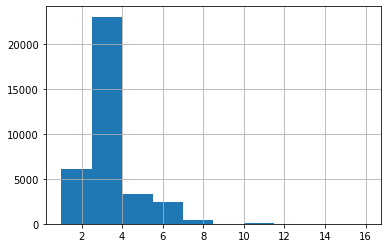

In [53]:
df_agg['post'].hist()

In [54]:
#2017 na value for offensiveYN

In [55]:
df_simple = df_simple[df_simple['offensiveYN'].notna()]

In [56]:
df_agg = df_simple.groupby(by=["clean_post"])['offensiveYN'].agg(lambda x:pd.Series.mode(x)[0]).reset_index()

In [57]:
df_agg

,clean_post,offensiveYN
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",1.0
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,0.0
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,1.0
3,\nDavid Knight‏ \n\nNotice how quickly things ...,0.0
4,\nFinland fireball: Time-lapse video shows nig...,0.0
...,...,...
35415,👉 Illegally in the country after 5 deportation...,0.0
35416,💥Breaking💥\nJulian Assange is the gate keeper ...,0.0
35417,📖 2Kings 22:19 because your heart was peniten...,0.0
35418,🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...,0.0


In [58]:
df_agg = df_simple.groupby(by=["clean_post"])['offensiveYN'].agg(pd.Series.mode).reset_index()

In [59]:
values = [0,0.5,1]
multi_mode = df_agg[~df_agg.offensiveYN.isin(values)]
multi_mode

,clean_post,offensiveYN
9,\nMany serial killers and all-around psychopat...,"[0.0, 0.5, 1.0]"
11,\nYou Tube has Censored our Channel because we...,"[0.0, 0.5, 1.0]"
22,"Isn’t it weird that in America, our flag and ...","[0.0, 0.5, 1.0]"
29,!!! RT @mayasolovely: As a woman you shouldn't...,"[0.5, 1.0]"
32,""" So hoes that smoke are losers ? "" yea ... go...","[0.0, 0.5, 1.0]"
...,...,...
35347,“I hope Trump is assassinated!” - Maria Chappe...,"[0.0, 0.5, 1.0]"
35383,“You incels are such LOSERS!”\n\- normie spend...,"[0.0, 0.5, 1.0]"
35389,‪Some nations die in flames and screams.‬\n\n‪...,"[0.0, 0.5, 1.0]"
35398,☊Oh great. The person who took twelve minutes ...,"[0.0, 0.5, 1.0]"


In [60]:
df_agg["offensiveYN"][~df_agg.offensiveYN.isin(values)] = 0.5
df_agg.head(30)

,clean_post,offensiveYN
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",1.0
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,0.0
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,1.0
3,\nDavid Knight‏ \n\nNotice how quickly things ...,0.0
4,\nFinland fireball: Time-lapse video shows nig...,0.0
5,\nICE\n\n“Today’s actions send a strong messag...,0.0
6,"\nIf family ""A"" went on a 2 month vacation,\na...",0.0
7,\nIsaiah 26:3\nYou will keep in perfect peace ...,0.0
8,\nJust watched facial recognition technology f...,1.0
9,\nMany serial killers and all-around psychopat...,0.5


In [61]:
len(multi_mode)

2431

In [62]:
df_agg['clean_post']

0        \n\nBill Kristol and Ben Shaprio, two turds in...
1        \n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...
2        \nCharlie Kirk‏\n\nJohnny Depp calls for death...
3        \nDavid Knight‏ \n\nNotice how quickly things ...
4        \nFinland fireball: Time-lapse video shows nig...
                               ...                        
35415    👉 Illegally in the country after 5 deportation...
35416    💥Breaking💥\nJulian Assange is the gate keeper ...
35417    📖 2Kings 22:19  because your heart was peniten...
35418    🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...
35419    🚨BREAKING: illegal alien 5x deported on 7 felo...
Name: clean_post, Length: 35420, dtype: object

In [63]:
df_agg['label']= [x if x!=0.5 else 3 for x in df_agg['offensiveYN']]

In [64]:
sentences = df_agg['clean_post'].values
#y = df_agg['label'].values

In [65]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df_agg['label'].values)
#test_y = le.transform(test_y.values)

In [66]:
from tensorflow.keras.utils import to_categorical

In [67]:
sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.20,  
                                                random_state=7)

In [68]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [69]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [70]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [71]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

In [72]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [73]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                                        vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [74]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt' ,
                                            tokenizer.word_index,  
                                            embedding_dim)

In [75]:
#  = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(128, activation='relu')(x)
# output = Dense(len(possible_labels), activation='sigmoid')(x)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=5)

Epoch 1/5
5668/5668 [==============================] - 1162s 205ms/step - loss: 0.8491 - accuracy: 0.6260 - val_loss: 0.7670 - val_accuracy: 0.6957
Epoch 2/5
5668/5668 [==============================] - 1147s 202ms/step - loss: 0.6707 - accuracy: 0.7395 - val_loss: 0.7688 - val_accuracy: 0.7013
Epoch 3/5
5668/5668 [==============================] - 1160s 205ms/step - loss: 0.5694 - accuracy: 0.7765 - val_loss: 0.8217 - val_accuracy: 0.6921
Epoch 4/5
5668/5668 [==============================] - 1195s 211ms/step - loss: 0.4500 - accuracy: 0.8189 - val_loss: 0.9249 - val_accuracy: 0.6801
Epoch 5/5
5668/5668 [==============================] - 738s 130ms/step - loss: 0.3487 - accuracy: 0.8574 - val_loss: 1.0056 - val_accuracy: 0.6375


In [ ]:
### incorporate numeric features/ categorical features

